In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [160]:
data = pd.read_csv('dataset_cian_itog.csv')

Рассмотрим данные на наличие пропусков и в каких признаках эти пропуски находятся

In [162]:
data.isnull().sum()

Unnamed: 0            0
room                 19
floor                18
floor_counts         18
square               13
price                25
metro_foot_minute     1
zone                  0
district             80
metro                 8
dtype: int64

Пропуски есть во многих признаках и логически сложно их заполнить, а также их не критически много относительно всего датасета, поэтому мы приняли решение просто удалить строчки с пропусками

In [163]:
data = data.dropna()

In [164]:
data = data.drop('Unnamed: 0', axis=1)

In [165]:
data_final = data[data['room'].isin([1, 2, 3])]

In [166]:
data_final.head(10)

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro
0,2.0,22.0,34.0,50.60,59236384.0,14.0,ЗАО,Дорогомилово,Кутузовская
1,3.0,7.0,10.0,190.00,139000000.0,5.0,ЦАО,Басманный,Бауманская
2,2.0,2.0,14.0,85.60,156750000.0,2.0,ЦАО,Якиманка,Боровицкая
3,3.0,3.0,15.0,104.00,65200000.0,7.0,САО,Аэропорт,Динамо
4,2.0,4.0,13.0,86.28,101797752.0,8.0,ЦАО,Мещанский,Цветной бульвар
5,2.0,7.0,12.0,78.00,102999000.0,6.0,ЦАО,Хамовники,Фрунзенская
6,2.0,8.0,9.0,64.50,89010000.0,1.0,ЦАО,Тверской,Маяковская
7,3.0,5.0,21.0,116.80,120000000.0,7.0,ЦАО,Пресненский,Улица 1905 года
8,2.0,3.0,27.0,58.00,30272464.0,18.0,ЮАО,Даниловский,Серпуховская
9,3.0,5.0,21.0,116.78,120000000.0,7.0,ЦАО,Пресненский,Улица 1905 года


## Предсказание стоимости квартиры по нескольким признакам

Мы решили спарсить данные с Циан, выделить основные признаки, выдвинуть гипотезы и обучить модель линейной регрессии, чтобы по основным характеристикам предсказывать цену квартиры

Описание переменных:
- `room` - количество комнат в квартире (от 1 до 3)
- `floor` - этаж, на котором располагается квартира
- `floor_counts` - общее количество этажей в доме
- `square` - площадь квартиры в квадратных метрах
- `price` - цена квартиры в рублях
- `metro_foot_minute` - расстояние до ближайшей станции метро в минутах ходьбы
- `zone` - административный округ Москвы
- `district` - район Москвы
- `metro` - ближайшая станция метро

Произведём первоначальный анализ признаков: для числовых построим корреляционную матрицу и гистограмму распределения, а для вещественных - столбчатую диаграмму.

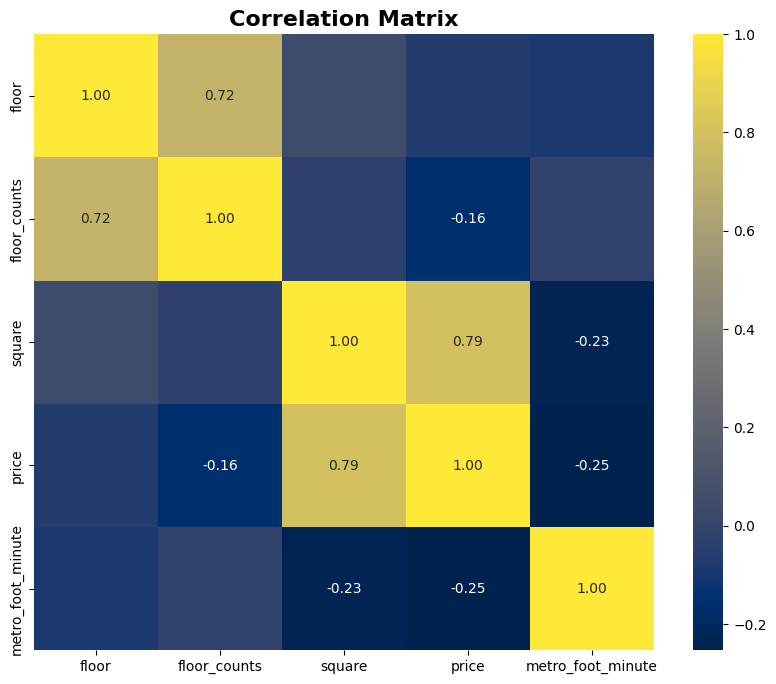

In [167]:
data_num_features = data_final.iloc[:, 1:6]
correlation_matrix = data_num_features.corr()
plt.figure(figsize=(10, 8))
map = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='cividis')
for t in map.texts:
    if float(t.get_text()) >= 0.1 or float(t.get_text()) <= -0.1:
        t.set_text(t.get_text())
    else:
        t.set_text("")
plt.title('Correlation Matrix', fontweight = 'bold', fontsize = 16)
plt.show()

**Вывод:** Мы видим, что есть сильная положительная взаимосвязь цены с площадью квартиры, а также заметная отрицательная связь с расстоянием до метро.

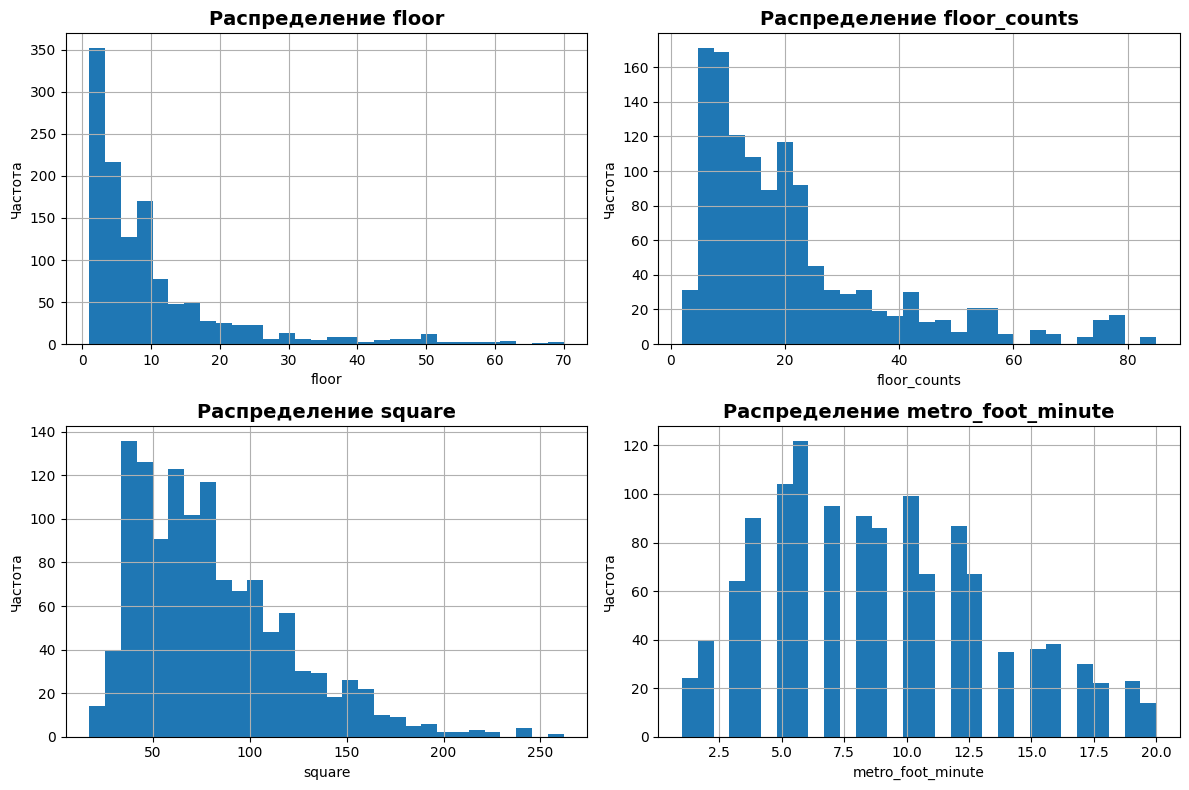

In [168]:
columns_to_plot = ['floor', 'floor_counts', 'square', 'metro_foot_minute']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(columns_to_plot):
    ax = axs[i // 2, i % 2]
    data_final[col].hist(bins=30, ax=ax)
    ax.set_title(f'Распределение {col}', fontweight = 'bold', fontsize = 14)
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')
plt.tight_layout()
plt.show()

**Вывод:** Можно заметить, что большинство объявлений относится к домам, общая этажность которых от 5 до 25. Также встречаются и более высотные дома (40, 60 и даже 80, скорее всего это аппартманты в Сити), но их гораздо меньше. Аналогичная распредление и для этажа, на котором находится сама квартира в объявлении. Большинство значений площади  сосредоточено от 25 до 125 квадратных метров, при этом встречаются и большие по площади квартиры. А вот распредление времени ходьбы до ближайшей станции метро близко к нормальному.

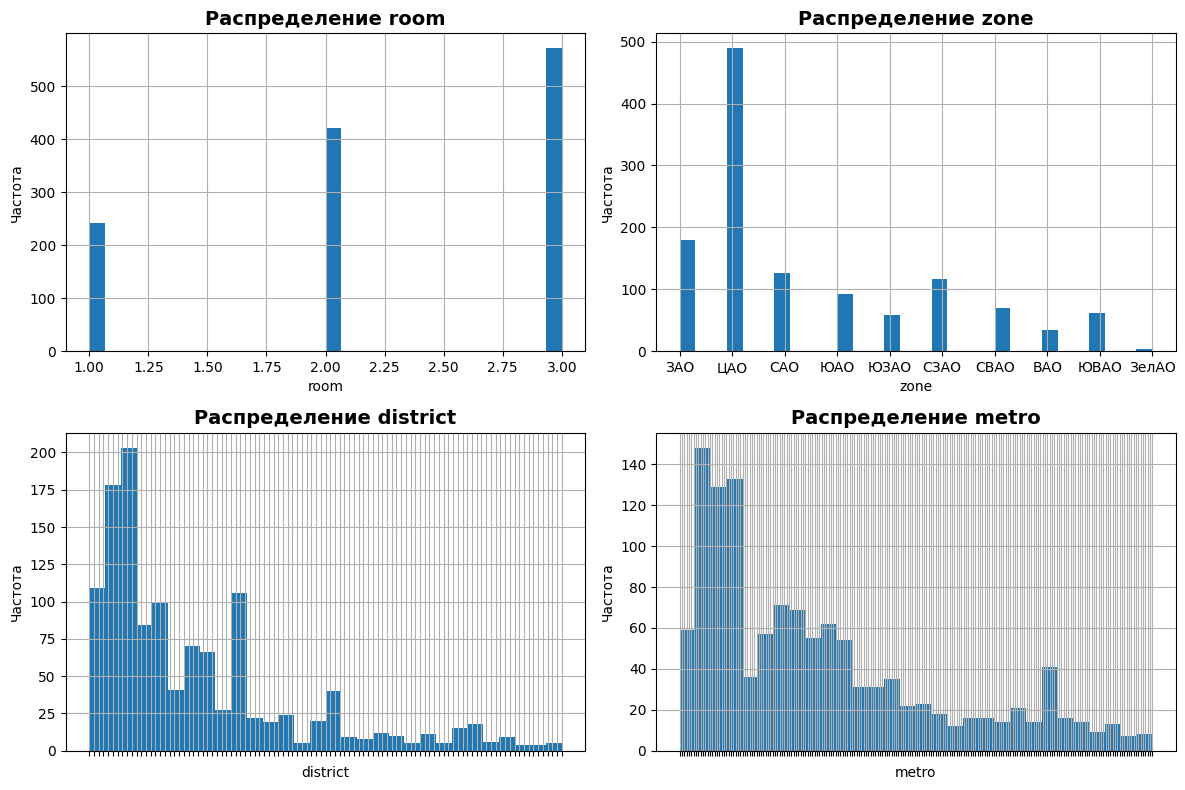

In [169]:
columns_to_plot = ['room', 'zone', 'district', 'metro']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(columns_to_plot):
    ax = axs[i // 2, i % 2]
    data_final[col].hist(bins=30, ax=ax)
    ax.set_title(f'Распределение {col}', fontweight = 'bold', fontsize = 14)
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')
    if i >= 2:
      ax.set_xticklabels([])
plt.tight_layout()
plt.show()

Можно заметить, что распределение категориальных признаков неравномерно, превалируют объекты из центральной части Москвы. Об этом можно судить по распределению признака *zone*, *disctrict* и *metro*. Также больше всего объявлений с 3-х комнатными квартирами

Посмотрим на распределение нашего таргета, т.е цены квартиры

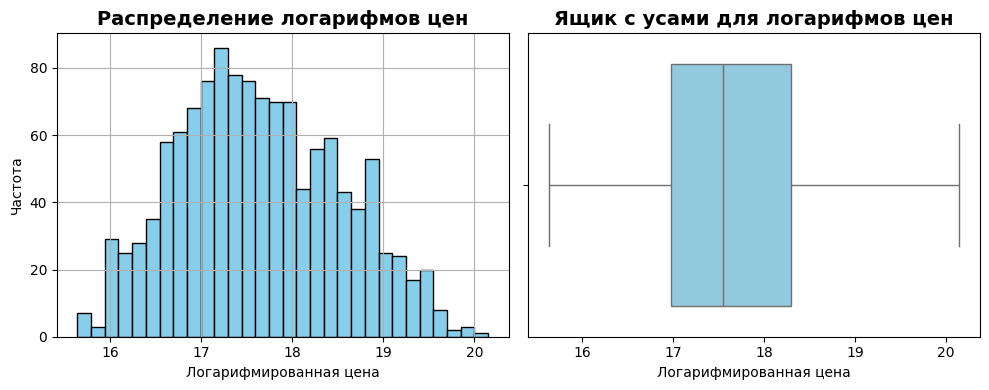

In [170]:
data_final.loc[:, 'log_price'] = np.log1p(data_final['price'])

log_price_column = data_final['log_price']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
log_price_column.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение логарифмов цен', fontweight = 'bold', fontsize = 14)
plt.xlabel('Логарифмированная цена')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=log_price_column, color='skyblue')
plt.title('Ящик с усами для логарифмов цен', fontweight = 'bold', fontsize = 14)
plt.xlabel('Логарифмированная цена')
plt.tight_layout()
plt.show()

**Вывод:** Логарифм распределения таргета (взят для уменьшения влияния выбросов) показывает распределение таргета, похожее на нормальное

## Попробуем создать несколько новых, логически подходящих для нашей модели, признаков

**1. Признак - относительная этажность**

In [171]:
data_final['floor_otn'] = data_final['floor'] / data_final['floor_counts']

Он может быть информативен, т.к. важен не только высокий этаж, но и относительно всей этажности дома, например, элитный низкоэтажный дом может стоить дороже несмотря на то, что сам этаж не высокий

**2. Признак - суммарное расстояние до метро**

In [172]:
data_final['total_metro'] = data_final['metro_foot_minute'] + data_final['floor']

Смысл даннного признака в том, что он премирует более низкие этажи, т.к. на них быстрее спускаться и меньше ждать лифт и т.д., решили сделать эту премию через время до метро, которое отрицательно влияет на цену

## Гипотеза 1: зависимость стоимости от площади

Первая гипотеза, которая, на первый взгляд, достаточно очевидна - это положительная зависимость стоимости квартиры от её метражности

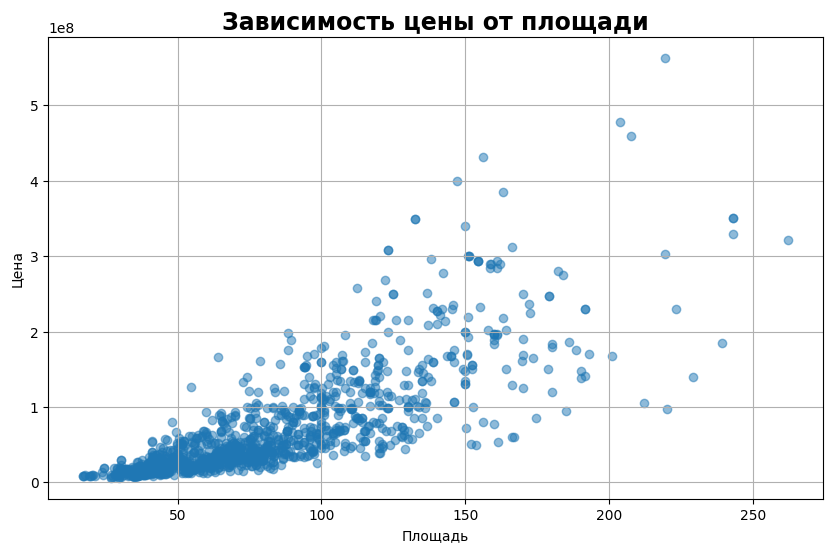

In [173]:
plt.figure(figsize=(10, 6))
plt.scatter(data_final['square'], data_final['price'], alpha=0.5)
plt.title('Зависимость цены от площади', fontweight = 'bold', fontsize = 17)
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

In [174]:
data_final['square'].corr(data_final['price'])

0.7944891565468162

**Вывод:** Видим очевидную положительную взаимосвязь стоимости квартиры и её площади. Также об этом позволяет судить очень высокий коэффициент корреляции Пирсона. Следовательно, данный признак точно является важным для обучения модели


## Гипотеза 2: зависимость стоимости от местоположения

Следующая гипотеза заключается в том, что чем ближе к центру расположена квартира, тем выше её стоимость

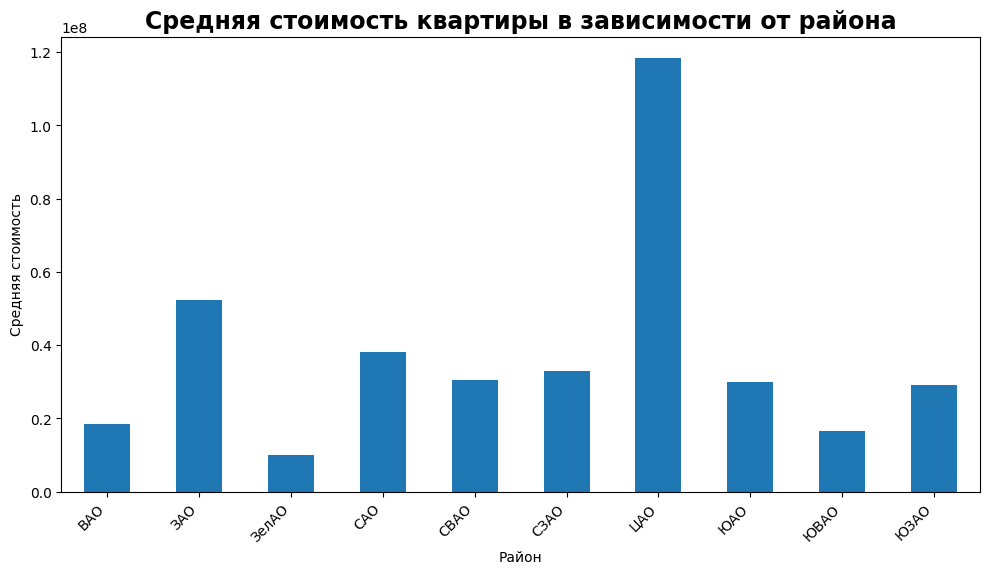

In [175]:
average_prices = data_final.groupby('zone')['price'].mean()

plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar')
plt.title('Средняя стоимость квартиры в зависимости от района', fontweight = 'bold', fontsize = 17)
plt.xlabel('Район')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Виден ярковыраженный всплеск стоимости в Центральном административном округе.

In [176]:
len(data_final['district'].unique())

101

Исходя из того, что распределение цены (логарифма цены) имеет схожее с нормальным распределение, разделим все квартиры на 3 категрии: дешевые, средние и дорогие. Пороговые значения цены можно получить, если вычесть из медианы стандартное отклонение и прибавить его соответственно

In [177]:
median_price = data_final['log_price'].median()
std_price = data_final['log_price'].std()

# Разделение на категории
bins = [0, median_price - std_price, median_price + std_price, np.inf]
labels = ['дешево', 'средне', 'дорого']
data_final['price category'] = pd.cut(data_final['log_price'], bins=bins, labels=labels, include_lowest=True)

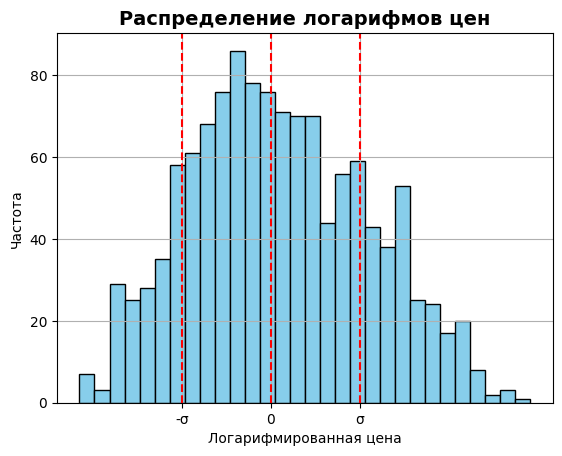

In [178]:
log_price_column.hist(bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=median_price, color='r', linestyle='--', label='Медиана')
plt.axvline(x=median_price - std_price, color='r', linestyle='--', label='-σ')
plt.axvline(x=median_price + std_price, color='r', linestyle='--', label='σ')
plt.xticks(ticks=[median_price])
plt.xticks(ticks=[median_price - std_price])
plt.xticks(ticks=[median_price + std_price])
plt.title('Распределение логарифмов цен', fontweight = 'bold', fontsize = 14)
plt.xlabel('Логарифмированная цена')
plt.ylabel('Частота')
ticks = [median_price, median_price - std_price, median_price + std_price]
labels = ['0', '-σ', 'σ']
plt.xticks(ticks=ticks, labels=labels)
plt.show()

Теперь проверим гипотезу с помощью критерия независимости Хи - квадрат. Для этого создадим таблицу сопряженности по признаками: район, ближайшая станция метро и категория цены.  

In [179]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(index=[data_final['district'], data_final['metro']], columns=data_final['price category'])
contingency_table

price category                    дешево  средне  дорого
district      metro                                     
Академический Академическая            0       2       0
              Ленинский проспект       0       1       0
              Профсоюзная              0       3       0
Алексеевский  Алексеевская             0       3       0
              ВДНХ                     0       1       0
...                                  ...     ...     ...
Якиманка      Третьяковская            0       0       2
              Шаболовская              0       2       0
Ярославский   ВДНХ                     0       1       0
Ясенево       Новоясеневская           2       0       0
              Ясенево                  1       0       0

[285 rows x 3 columns]

In [180]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(1584.2751129914898, 9.031541641937148e-97)

**Вывод:** p-value критерия очень маленькое, следовательно отвергаем нулевую гипотезу о независимости признаков. Значит, взаимосвязь между районом, ближайшей станцией метро и стоимостью квартиры действительно есть

## Гипотеза 3: зависимость стоимости квартиры от этажа, на котором она расположена и от этажности дома в целом

1. Есть гипотеза, что чем выше этаж квартиры, на котором она расположена, тем она дороже, но при этом чем ниже в целом дом, тем также выше стоимость квартиры

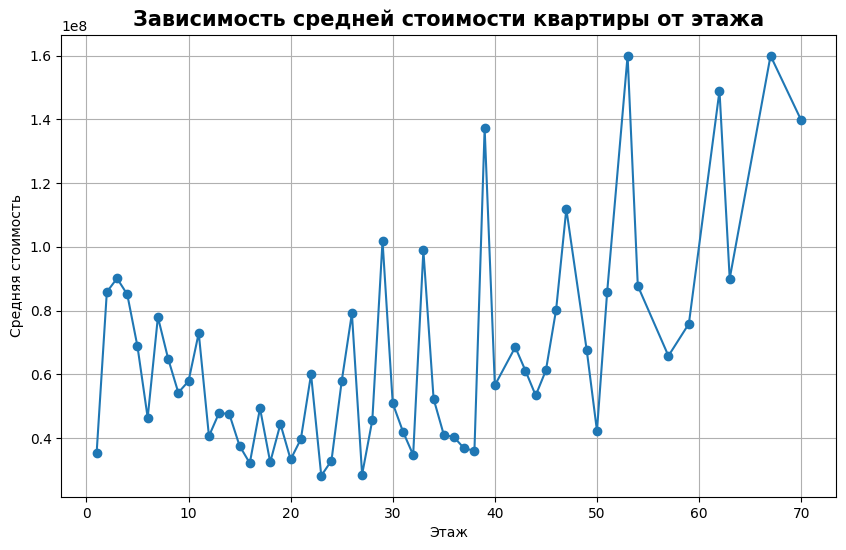

In [181]:
average_prices_by_floor = data_final.groupby('floor')['price'].mean()

plt.figure(figsize=(10, 6))
average_prices_by_floor.plot(kind='line', marker='o')
plt.title('Зависимость средней стоимости квартиры от этажа', fontweight = 'bold', fontsize = 15)
plt.xlabel('Этаж')
plt.ylabel('Средняя стоимость')
plt.grid(True)
plt.show()

Видна закономерность, что низкие этажи и очень высокие стоят в среднем дороже, чем средние этажи, что не совсем подтверждает гипотезу, понятнее станет, когда обучим модель и посмотрим вес данного признака, возможно будет необходимо поделить его на низкие, средние и высокие этажи

2. Теперь посмотрим на зависимость цены от этажности всего здания

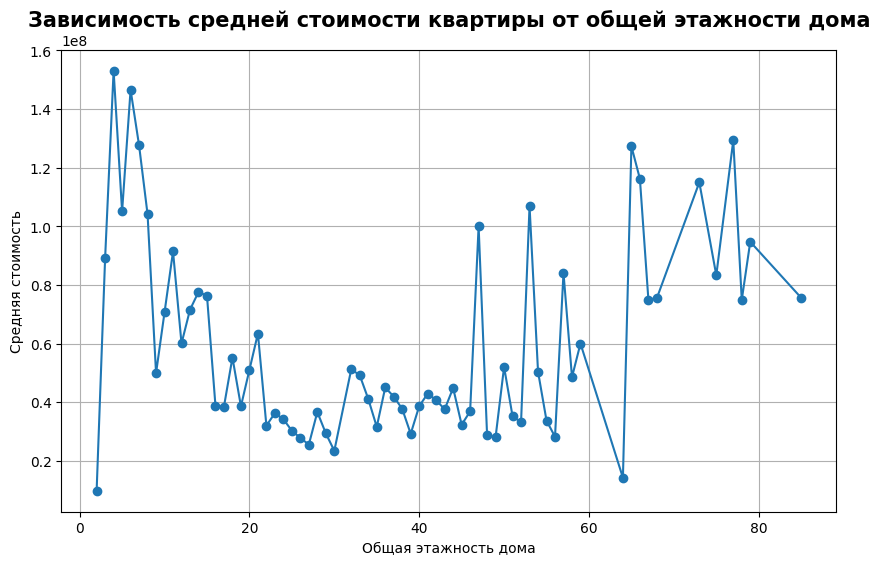

In [182]:
average_prices_by_floor_count = data_final.groupby('floor_counts')['price'].mean()

plt.figure(figsize=(10, 6))
average_prices_by_floor_count.plot(kind='line', marker='o')
plt.title('Зависимость средней стоимости квартиры от общей этажности дома', fontsize = 15, fontweight = 'bold')
plt.xlabel('Общая этажность дома')
plt.ylabel('Средняя стоимость')
plt.grid(True)
plt.show()

**Вывод:** На графике не видно какой-либо прямой зависимости, также видна логика, что в домах средней этажности стоимость ниже, чем в низкоэтажных и в небоскрёбах выше условно 65 этажей. Скорее всего, это произошло из-за дисбаланса признака этажности дома

## Гипотеза 4: стоимость квартиры положительно зависит от расстояния до ближайшего метро

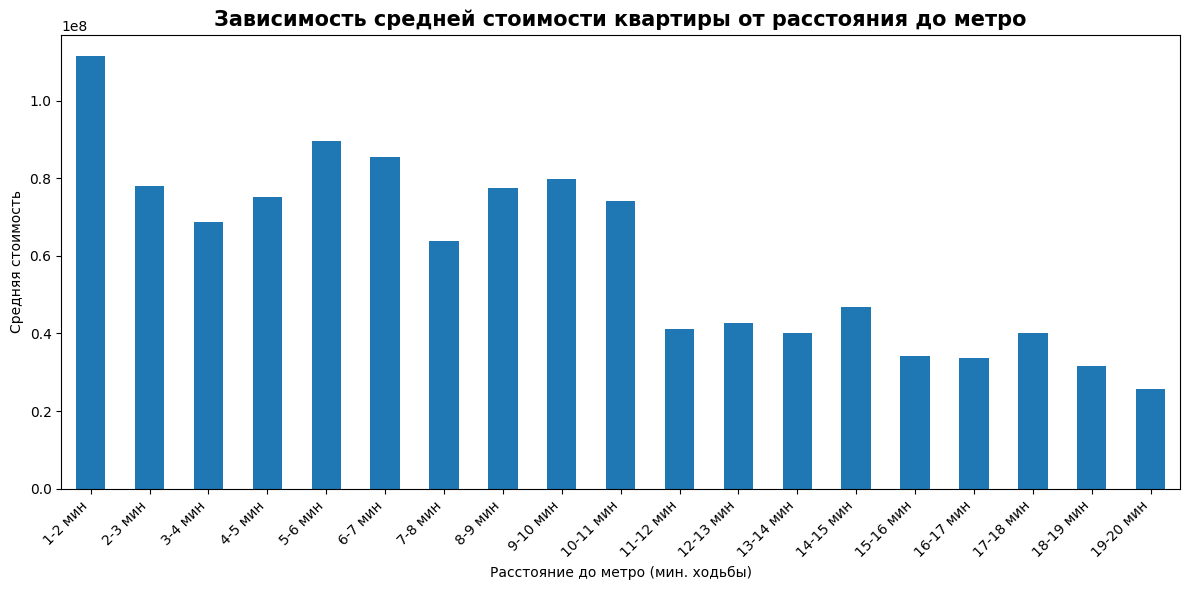

In [183]:
bins = range(1, 21)
labels = [f'{i}-{i+1} мин' for i in bins[:-1]]
data_final['metro_range'] = pd.cut(data_final['metro_foot_minute'], bins=bins, labels=labels, include_lowest=True)

average_prices_by_metro_range = data_final.groupby('metro_range')['price'].mean()
average_prices_by_metro_range.index = average_prices_by_metro_range.index.astype(str)

plt.figure(figsize=(12, 6))
average_prices_by_metro_range.plot(kind='bar')
plt.title('Зависимость средней стоимости квартиры от расстояния до метро', fontsize=15, fontweight='bold')
plt.xlabel('Расстояние до метро (мин. ходьбы)')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Вывод:** видна зависимость средней стоимости квартиры от времени до метро, скорее всего, этот признак будет важным при обучении линейной регресии

## Гипотеза 5: признак *floor* (этаж квартиры) и *floor_counts* (этажность дома) имееют похожее распредление, тогда можно будет исключить  один из признаков, поскольку он не вносит дополнительного вклада в модель.

Для этого будем использовать двухвыборочный тест Колмагора - Смирнова

In [184]:
from scipy import stats
stats.ks_2samp(data_final['floor'], data_final['floor_counts'])

KstestResult(statistic=0.41085899513776336, pvalue=1.3829407534081613e-93, statistic_location=8.0, statistic_sign=1)

**Вывод:** p-value получился очень маленьким, следовательно, гипотеза о схожести распределения признаков неверна и мы будем учитывать оба при обучении модели

## Подготовка данных и обучение модели

**1. Логарифимируем целевую переменную для борьбы с выбросами**

In [186]:
data_final = data_final.drop('metro_range', axis=1)


In [188]:
data_final = data_final.drop('price category', axis=1)

In [190]:
data_final_log = data_final.copy()


In [192]:
data_final_log['price'] = np.log(data_final_log['price'])

**2. Теперь закодируем категориальные признаки через OHE**

In [193]:
data_final_log.head()

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro,log_price,floor_otn,total_metro
0,2.0,22.0,34.0,50.60,17.897047,14.0,ЗАО,Дорогомилово,Кутузовская,17.897047,0.647059,36.0
1,3.0,7.0,10.0,190.00,18.749984,5.0,ЦАО,Басманный,Бауманская,18.749984,0.700000,12.0
2,2.0,2.0,14.0,85.60,18.870163,2.0,ЦАО,Якиманка,Боровицкая,18.870163,0.142857,4.0
3,3.0,3.0,15.0,104.00,17.992970,7.0,САО,Аэропорт,Динамо,17.992970,0.200000,10.0
4,2.0,4.0,13.0,86.28,18.438499,8.0,ЦАО,Мещанский,Цветной бульвар,18.438499,0.307692,12.0


In [194]:
categorical_columns = ['room', 'zone', 'district', 'metro']
data_final_log_encoded = pd.get_dummies(data_final_log, columns=categorical_columns, drop_first=True, dtype='int64')

In [195]:
data_final_log_encoded.head()

,floor,floor_counts,square,price,metro_foot_minute,log_price,floor_otn,total_metro,room_2.0,room_3.0,...,metro_Шелепиха,metro_Шипиловская,metro_Щербинка,metro_Щукинская,metro_Щёлковская,metro_Электрозаводская,metro_Юго,metro_Южная,metro_Ясенево,metro_Яхромская
0,22.0,34.0,50.60,17.897047,14.0,17.897047,0.647059,36.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,10.0,190.00,18.749984,5.0,18.749984,0.700000,12.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.0,14.0,85.60,18.870163,2.0,18.870163,0.142857,4.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,15.0,104.00,17.992970,7.0,17.992970,0.200000,10.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.0,13.0,86.28,18.438499,8.0,18.438499,0.307692,12.0,1,0,...,0,0,0,0,0,0,0,0,0,0


**3. Выделим признаки и целевую переменную**

In [196]:
X = data_final_log_encoded.drop(['price','log_price'], axis=1)
y = data_final_log_encoded['price']

**4. Разделим выборку на обучающую и тестовую, отмасштабируем признаки и обучим модель**

In [197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [198]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_train_sc.head()

,floor,floor_counts,square,metro_foot_minute,floor_otn,total_metro,room_2.0,room_3.0,zone_ЗАО,zone_ЗелАО,...,metro_Шелепиха,metro_Шипиловская,metro_Щербинка,metro_Щукинская,metro_Щёлковская,metro_Электрозаводская,metro_Юго,metro_Южная,metro_Ясенево,metro_Яхромская
0,-0.641293,1.050531,0.006295,0.498633,-1.517957,-0.432908,1.342367,-0.923001,-0.411554,-0.048196,...,-0.176248,-0.03406,0.0,-0.09673,-0.03406,-0.03406,-0.059062,-0.03406,-0.03406,-0.03406
1,-0.554548,-1.022901,0.717792,-0.175850,1.795440,-0.600216,-0.744953,1.083422,-0.411554,-0.048196,...,-0.176248,-0.03406,0.0,-0.09673,-0.03406,-0.03406,-0.059062,-0.03406,-0.03406,-0.03406
2,-0.554548,-0.792520,1.316154,-1.075161,0.004415,-0.934833,-0.744953,1.083422,-0.411554,-0.048196,...,-0.176248,-0.03406,0.0,-0.09673,-0.03406,-0.03406,-0.059062,-0.03406,-0.03406,-0.03406
3,0.312907,-0.101376,1.283471,1.847599,0.720825,0.989213,-0.744953,1.083422,-0.411554,-0.048196,...,-0.176248,-0.03406,0.0,-0.09673,-0.03406,-0.03406,-0.059062,-0.03406,-0.03406,-0.03406
4,-0.814784,-0.274162,-0.219977,-0.400678,-1.575902,-0.934833,-0.744953,1.083422,-0.411554,-0.048196,...,-0.176248,-0.03406,0.0,-0.09673,-0.03406,-0.03406,-0.059062,-0.03406,-0.03406,-0.03406


In [199]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train_sc, y_train)

LinearRegression()

In [200]:
data_final_log.head()

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro,log_price,floor_otn,total_metro
0,2.0,22.0,34.0,50.60,17.897047,14.0,ЗАО,Дорогомилово,Кутузовская,17.897047,0.647059,36.0
1,3.0,7.0,10.0,190.00,18.749984,5.0,ЦАО,Басманный,Бауманская,18.749984,0.700000,12.0
2,2.0,2.0,14.0,85.60,18.870163,2.0,ЦАО,Якиманка,Боровицкая,18.870163,0.142857,4.0
3,3.0,3.0,15.0,104.00,17.992970,7.0,САО,Аэропорт,Динамо,17.992970,0.200000,10.0
4,2.0,4.0,13.0,86.28,18.438499,8.0,ЦАО,Мещанский,Цветной бульвар,18.438499,0.307692,12.0


**5. Посчитаем MSE на тренировочной и тестовой выборках**

In [201]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
y_pred_train = model.predict(X_train_sc)
y_pred_test = model.predict(X_test_sc)

print(f'MSE для тренировочной выборки: {mean_squared_error(y_train, y_pred_train)}')
print(f'MSE для тестовой выборки: {mean_squared_error(y_test, y_pred_test)}')

MSE для тренировочной выборки: 0.06791953471147709
MSE для тестовой выборки: 2.0426893784821443e+26


**6. Оценим модель на переобучение, посмотрев на коэффициенты переменных**

In [202]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coefficients['AbsCoefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('AbsCoefficient', ascending=False)
coefficients = coefficients.drop('AbsCoefficient', axis=1)
coefficients

,Feature,Coefficient
85,district_Северное Бутово,-1.583098e+13
138,metro_Бульвар Дмитрия Донского,1.583098e+13
152,metro_Говорово,-1.558935e+13
179,metro_Красносельская,1.216874e+13
30,district_Восточное Дегунино,-1.143313e+13
...,...,...
117,metro_Автозаводская,0.000000e+00
282,metro_Тимирязевская,0.000000e+00
302,metro_Ховрино,0.000000e+00
293,metro_Улица Дмитриевского,0.000000e+00


Можем заметить, что веса очень большие, что может говорить о переобучении модели, поэтому нужно добавить регуляризацию.

Будем использовать Lasso-регуляризацию, потому что она зануляет ненужные признаки, а у нас очень много признаков и таким образом мы возьмём только самые информативные.

С помощью кросс-валидации найдём самый оптимальный коэффициент альфа для регуляризации

In [203]:
from sklearn.linear_model import LassoCV, Lasso
alphas = [0.1, 1, 10, 100, 200]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_sc, y_train)
mse_path = lasso_cv.mse_path_
mean_mse = np.mean(mse_path, axis=1)
best_alpha_index = np.argmin(mean_mse)
best_alpha = lasso_cv.alphas_[best_alpha_index]
print(f"Наиболее оптимальное значение alpha: {best_alpha}")

Наиболее оптимальное значение alpha: 0.1


In [204]:
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_sc, y_train)

Lasso(alpha=0.1)

In [205]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
coefficients['AbsCoefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('AbsCoefficient', ascending=False)
coefficients = coefficients.drop('AbsCoefficient', axis=1)
coefficients[:10]

,Feature,Coefficient
2,square,0.511048
13,zone_ЦАО,0.247988
15,zone_ЮВАО,-0.008818
37,district_Дорогомилово,0.005278
0,floor,-0.000000
219,metro_Озёрная,-0.000000
218,metro_Новые Черёмушки,0.000000
217,metro_Новоясеневская,-0.000000
216,metro_Новослободская,0.000000
215,metro_Новокузнецкая,0.000000


In [206]:
y_pred_train = lasso.predict(X_train_sc)
y_pred_test = lasso.predict(X_test_sc)

print(f'MSE для тренировочной выборки: {mean_squared_error(y_train, y_pred_train)}')
print(f'MSE для тестовой выборки: {mean_squared_error(y_test, y_pred_test)}')

MSE для тренировочной выборки: 0.17549695855046385
MSE для тестовой выборки: 0.18839969534955686


Можно заметить, что при добавлении регуляризации веса значительно уменьшились, а качество модели на тестовой выборке значительно выросло. Как и предполагалось, наибольший вес имеет площаль квартиры, а также распложение: ЦАО, сильно увеличивающий стоимость, а также ЮВАО - уменьшающий ее. Помимо этого увеличивает стоимость район Дорогомилово, находящийся радом с ЦАО, веса остальных признаков занулились. Можно утверждать, что мы обучили хорошую модель по предсказанию стоимости квартиры

